In [2]:
#Na zaciatku sme si importovali vsetky potrebne kniznice 
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
import shap


In [3]:
# ======================================================================
#                  Data Loading and Initial Preparation
# ======================================================================
# V tejto casti sme vykonali ncítanie dát, čistenie od irelevantných stĺpcov
# a výber iba tých atribútov, ktoré budeme ďalej spracovávať.
# V tejto casti sme zacali s prvými krokmi k tomu, aby sme vytvorili čistý dataset.

# Nastavenie stýlu pre vizualizácie
sns.set(style="whitegrid")

print("==== 1. Data Loading and Initial Preparation ====")

df = pd.read_csv('insurance_data.csv')

# Odstranenime stlpce, ktoré nie sú relevantné pre analýzu, kvoli velkej rozmanitosti hodnot
df = df.drop(columns=['policy_number', 'policy_annual_premium'])
print("Dropped 'policy_number' and 'policy_annual_premium'.")

# Výber kategorizovaných a numerických premenných pre ďalšiu prácu s datasetom
selected_categorical_cols = [
    'incident_severity', 'incident_date', 'incident_location',
    'authorities_contacted', 'collision_type', 'insured_hobbies',
    'incident_state', 'incident_type', 'incident_city', 'auto_make', 'policy_csl'
]
selected_numerical_cols = [
    'vehicle_claim', 'total_claim_amount', 'property_claim',
    'injury_claim', 'number_of_vehicles_involved', 'age', 'months_as_customer'
]

# Spojili sme si vybrané atributy s cielovou premennou
cols_to_keep = selected_categorical_cols + selected_numerical_cols + ['fraud_reported']
df_selected = df[cols_to_keep].copy()

# Zobrazili sme si základne informácie a prehlad o datach
print("\nFirst rows of selected data:")
print(df_selected.head())
print("\nData information:")
print(df_selected.info())
print("\nDescriptive statistics:")
print(df_selected.describe())
print("\nTarget variable distribution:")
print(df_selected['fraud_reported'].value_counts())
print("-" * 70)


==== 1. Data Loading and Initial Preparation ====
Dropped 'policy_number' and 'policy_annual_premium'.

First rows of selected data:
  incident_severity        incident_date  incident_location  \
0      Major Damage  2015-01-25 00:00:00     9935 4th Drive   
1      Minor Damage  2015-01-21 00:00:00       6608 MLK Hwy   
2      Minor Damage  2015-02-22 00:00:00  7121 Francis Lane   
3      Major Damage  2015-01-10 00:00:00   6956 Maple Drive   
4      Minor Damage  2015-02-17 00:00:00       3041 3rd Ave   

  authorities_contacted   collision_type insured_hobbies incident_state  \
0                Police   Side Collision        sleeping             SC   
1                Police                ?         reading             VA   
2                Police   Rear Collision     board-games             NY   
3                Police  Front Collision     board-games             OH   
4                   NaN                ?     board-games             NY   

              incident_type incident_

In [4]:
# ======================================================================
#              Data Preparation and Feature Engineering
# ======================================================================
# V tejto časti sme si pripravili dataset na modelovanie pre dalšiu cast:
# Ošetrrili sme chýbajúce hodnoty pre atribúty collision_type a authorities_contacted pomocou vhodných metod
# Konvertovali sme cielovu premmennu pomocou Label encoder 
# Vytvorili sme nové relevantvé atribúty (features) pomocou feature engineering
# Tiež sme potrebovali zakódovat kategorizované premenné podla vhodných metod
print("\n==== Data Preparation and Feature Engineering ====")
df_prepared = df_selected.copy()

# Osetrili sme chybajuce hodnoty pomocou mode() teda najcastejsou hodnotou
print("Handling missing values...")
df_prepared['collision_type'] = df_prepared['collision_type'].replace('?', np.nan)
df_prepared['collision_type'].fillna(df_prepared['collision_type'].mode()[0], inplace=True)

df_prepared['authorities_contacted'] = df_prepared['authorities_contacted'].replace(
    ['nan', 'NaN'], np.nan
)
df_prepared['authorities_contacted'].fillna(
    df_prepared['authorities_contacted'].mode()[0], inplace=True
)

print(f"collision_type missing after handling: {df_prepared['collision_type'].isna().sum()}")
print(f"authorities_contacted missing after handling: {df_prepared['authorities_contacted'].isna().sum()}")

# Previedli sme cieľou premennu na numerickú
print("Encoding target variable 'fraud_reported'...")
df_prepared['fraud_reported'] = LabelEncoder().fit_transform(df_prepared['fraud_reported'])

# Extrahovali sme časove črty z dátumu
print("Extracting features from 'incident_date'...")
df_prepared['incident_date'] = pd.to_datetime(df_prepared['incident_date'], errors='coerce')
if df_prepared['incident_date'].isnull().any():
    print(f"Warning: {df_prepared['incident_date'].isnull().sum()} missing dates found. Filling with mode.")
    mode_date = df_prepared['incident_date'].mode()[0]
    df_prepared['incident_date'].fillna(mode_date, inplace=True)

df_prepared['incident_year'] = df_prepared['incident_date'].dt.year
df_prepared['incident_month'] = df_prepared['incident_date'].dt.month
df_prepared['incident_day'] = df_prepared['incident_date'].dt.day
df_prepared['incident_day_of_week'] = df_prepared['incident_date'].dt.dayofweek
df_prepared.drop('incident_date', axis=1, inplace=True)

# Feature engineering: tvorba nových premenných odvodených z existujúcich
print("Creating new engineered features...")
df_prepared['total_damage_ratio'] = (
    df_prepared['vehicle_claim'] +
    df_prepared['property_claim'] +
    df_prepared['injury_claim']
) / (df_prepared['total_claim_amount'] + 1e-9)

df_prepared['avg_claim_per_vehicle'] = (
    df_prepared['total_claim_amount'] /
    (df_prepared['number_of_vehicles_involved'] + 1e-9)
)

df_prepared['is_major_incident'] = (
    df_prepared['incident_severity'] == 'Major Damage'
).astype(int)

df_prepared['long_term_customer'] = (
    df_prepared['months_as_customer'] > 60
).astype(int)

df_prepared['high_cost_claim'] = (
    df_prepared['total_claim_amount'] > df_prepared['total_claim_amount'].median()
).astype(int)

df_prepared['multi_claim_type'] = (
    (df_prepared['vehicle_claim'] > 0).astype(int) +
    (df_prepared['property_claim'] > 0).astype(int) +
    (df_prepared['injury_claim'] > 0).astype(int)
) > 1
df_prepared['multi_claim_type'] = df_prepared['multi_claim_type'].astype(int)

total_components = (
    df_prepared['vehicle_claim'] +
    df_prepared['property_claim'] +
    df_prepared['injury_claim']
)
df_prepared['claim_ratio'] = df_prepared['total_claim_amount'] / (total_components + 1e-9)
df_prepared['age_squared'] = df_prepared['age']**2
df_prepared['customer_tenure_squared'] = df_prepared['months_as_customer']**2

# Zakódovanie kategorizovaných premenných
print("Encoding categorical features (pre-split steps: Ordinal, Frequency)...")

# Ordinal encoding pre incident_severity
ordinal_cols = ['incident_severity']
le_severity = LabelEncoder()
df_prepared['incident_severity'] = le_severity.fit_transform(df_prepared['incident_severity'])
print(f"Incident severity mapping: {list(le_severity.classes_)} -> {le_severity.transform(le_severity.classes_)}")

# Ostatné kategórie budeme kódovať až po rozdelení dát (target encoding)
nominal_cols_freq = ['incident_city', 'auto_make', 'incident_location']
for col in nominal_cols_freq:
    freq_map = df_prepared[col].value_counts(normalize=False).to_dict()
    df_prepared[col + '_freq'] = df_prepared[col].map(freq_map)
    df_prepared.drop(col, axis=1, inplace=True)
    print(f"Frequency encoded and dropped: {col}")

nominal_cols_target_for_pipeline = [
    'collision_type', 'authorities_contacted', 'insured_hobbies',
    'incident_state', 'policy_csl', 'incident_type'
]
print(f"Target encoding for: {nominal_cols_target_for_pipeline} will be applied AFTER train/test split.")

# Záverečná kontrola pripraveného datasetu
print("\nFinal dataset info BEFORE TRAIN/TEST SPLIT:")
print(df_prepared.info())
print("\nMissing values summary BEFORE TRAIN/TEST SPLIT:")
print(df_prepared.isnull().sum())
print("-" * 70)



==== 3. Data Preparation and Feature Engineering ====
Handling missing values...
collision_type missing after handling: 0
authorities_contacted missing after handling: 0
Encoding target variable 'fraud_reported'...
Extracting features from 'incident_date'...
Creating new engineered features...
Encoding categorical features (pre-split steps: Ordinal, Frequency)...
Incident severity mapping: ['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'] -> [0 1 2 3]
Frequency encoded and dropped: incident_city
Frequency encoded and dropped: auto_make
Frequency encoded and dropped: incident_location
Target encoding for: ['collision_type', 'authorities_contacted', 'insured_hobbies', 'incident_state', 'policy_csl', 'incident_type'] will be applied AFTER train/test split.

Final dataset info BEFORE TRAIN/TEST SPLIT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------

C:\Users\Miriam\AppData\Local\Temp\ipykernel_16116\4073521364.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prepared['collision_type'].fillna(df_prepared['collision_type'].mode()[0], inplace=True)
C:\Users\Miriam\AppData\Local\Temp\ipykernel_16116\4073521364.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [5]:
# ======================================================================
#                  Model Training Pipeline
# ======================================================================
# V tejto casti ideme pripraviť dáta pre modelovanie, aplikovať zakódovanie, potom normalizáciu, sampling a výber najlepších atributov
print("\n==== Model Training Pipeline ====")

# Najprv sme rozdelili dáta na trénovaciu a testovaciu sadu, aby sme vedeli model trénovať a neskôr otestovať na neznámych dátach. 
#Stratifikácia zabezpečí rovnaký pomer tried (fraud vs. non-fraud) v oboch množinách.
X = df_prepared.drop('fraud_reported', axis=1)
y = df_prepared['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

# Niektoré kategórie môžu byť informatívne z hľadiska podielu podvodov – preto použijeme "target encoding", kde každá kategória získa hodnotu podľa pravdepodobnosti výskytu podvodu v danej skupine. Robí sa až po rozdelení dát, aby sme predišli úniku informácií (data leakage).
print("\nApplying Target Encoding to train and test sets (post-split)...")
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in nominal_cols_target_for_pipeline:
    temp_train_df = X_train_encoded[[col]].copy()
    temp_train_df['fraud_reported'] = y_train
    target_map = temp_train_df.groupby(col)['fraud_reported'].mean().to_dict()

    X_train_encoded[col + '_target'] = X_train_encoded[col].map(target_map)
    X_test_encoded[col + '_target'] = X_test_encoded[col].map(target_map)
    overall_train_mean = y_train.mean()
    X_test_encoded[col + '_target'].fillna(overall_train_mean, inplace=True)

    X_train_encoded.drop(col, axis=1, inplace=True)
    X_test_encoded.drop(col, axis=1, inplace=True)
    print(f"  - Target encoded and dropped: {col}")

X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_test_encoded.columns, index=X_test_encoded.index)

# Niektoré algoritmy sú citlivé na rozsah hodnôt, preto numerické dáta škálujeme pomocou StandardScaler tak, aby mali nulový priemer a jednotkovú odchýlku.
print("\nScaling numerical features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

feature_names_after_encoding = X_train_encoded.columns.tolist()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_after_encoding, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names_after_encoding, index=X_test_encoded.index)
print(f"Data scaled. Total features: {X_train_scaled.shape[1]}")

# Dáta sú nevyvážené (málo podvodov), čo môže viesť k nepresnému modelu. Preto pomocou techník SMOTE a ADASYN vygenerujeme nové syntetické vzorky pre menšinovú triedu.
print("\nApplying Over-sampling (SMOTE, ADASYN) on scaled training data...")
smote = SMOTE(sampling_strategy=1, random_state=42)
adasyn = ADASYN(sampling_strategy=1, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

X_train_smote = pd.DataFrame(X_train_smote, columns=feature_names_after_encoding)
X_train_adasyn = pd.DataFrame(X_train_adasyn, columns=feature_names_after_encoding)

print(f"SMOTE training samples: {X_train_smote.shape[0]} (Fraud: {y_train_smote.value_counts()[1]}, Non-Fraud: {y_train_smote.value_counts()[0]})")
print(f"ADASYN training samples: {X_train_adasyn.shape[0]} (Fraud: {y_train_adasyn.value_counts()[1]}, Non-Fraud: {y_train_adasyn.value_counts()[0]})")

# Použijeme metódu výberu atribútov, ktorá vyberie tie najviac informatívne – konkrétne 15 najlepších atribútov pomocou f_classif, teda ANOVA F-testu.
print("\nApplying Feature Selection with KBest...")
select_k_best_smote = SelectKBest(f_classif, k=15)
X_train_selected_kbest_smote = select_k_best_smote.fit_transform(X_train_smote, y_train_smote)
X_test_selected_kbest_smote = select_k_best_smote.transform(X_test_scaled)
print(f"KBest selected {X_train_selected_kbest_smote.shape[1]} features.")
selected_kbest_features = X_train_smote.columns[select_k_best_smote.get_support()].tolist()

feature_selection_methods_smote_data = {
    "KBest": (X_train_selected_kbest_smote, X_test_selected_kbest_smote, selected_kbest_features),
}

print("-" * 70)

# V tejto časti kódu definuje funkcie pre vyhodnotenie modelov a ich následné porovnávanie.
# Ide o kľúčový krok v procese vývoja a optimalizácie strojového učenia, kde  cyklicky
# testujeme rôzne modely a prístupy, aby sme nasli co najlepší model.
#Definovali sme si vyhodnocovacie funckie kde n8sledne meriame výkony modelov na testovacích a trénovacích dátach (pomocou krížovej validácie)
#Inicializovali sme si modely ktore obsahuju rôzne typy klasifikačných modelov, kde sme nasledne bude realizovane hodnotenie a porovnavanie kazdeho modelu

def evaluate_model(model, X_train_eval, y_train_eval, X_test_eval, y_test_eval, model_name, data_context="", feature_selection_method=None):
    start_time = time.time()
    model.fit(X_train_eval, y_train_eval)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test_eval)
    try:
        y_pred_proba = model.predict_proba(X_test_eval)[:, 1]
    except AttributeError:
        y_pred_proba = None

    print(f"\n--- {model_name} - Evaluation on Test Set ---")
    if data_context:
        print(f"  Data Context: {data_context}")
    if feature_selection_method:
        print(f"  Feature Selection: {feature_selection_method}")

    print(classification_report(y_test_eval, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_eval, y_pred)
    print(cm)

    accuracy = accuracy_score(y_test_eval, y_pred)
    precision = precision_score(y_test_eval, y_pred)
    recall = recall_score(y_test_eval, y_pred)
    f1 = f1_score(y_test_eval, y_pred)
    roc_auc = roc_auc_score(y_test_eval, y_pred_proba) if y_pred_proba is not None else np.nan

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu",
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix ({data_context})")
    plt.show()

    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test_eval, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve ({data_context})")
        plt.legend()
        plt.show()
    else:
        print("ROC curve not available for this model.")

    return model

def evaluate_model_cv(model, X_train_cv, y_train_cv, model_name, n_splits=5, data_context="", feature_selection_method=None):
    print(f"\n--- {model_name} - Cross-Validation Results ---")
    if data_context:
        print(f"  Data Context: {data_context}")
    if feature_selection_method:
        print(f"  Feature Selection: {feature_selection_method}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train_cv, y_train_cv, cv=skf, scoring=scoring, n_jobs=-1)

    print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f} (+/- {np.std(cv_results['test_accuracy']):.4f})")
    print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f} (+/- {np.std(cv_results['test_precision']):.4f})")
    print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f} (+/- {np.std(cv_results['test_recall']):.4f})")
    print(f"Average F1 Score: {np.mean(cv_results['test_f1']):.4f} (+/- {np.std(cv_results['test_f1']):.4f})")
    print(f"Average AUC: {np.mean(cv_results['test_roc_auc']):.4f} (+/- {np.std(cv_results['test_roc_auc']):.4f})")
    print("-" * 50)

# Tu sme si definovali modely co chceme pouzivat a trenovat
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
}
print("-" * 70)



==== 4. Model Training Pipeline ====
Data split into training (700 samples) and testing (300 samples).
Train target distribution:
fraud_reported
0    0.752857
1    0.247143
Name: proportion, dtype: float64
Test target distribution:
fraud_reported
0    0.753333
1    0.246667
Name: proportion, dtype: float64

Applying Target Encoding to train and test sets (post-split)...
  - Target encoded and dropped: collision_type
  - Target encoded and dropped: authorities_contacted
  - Target encoded and dropped: insured_hobbies
  - Target encoded and dropped: incident_state
  - Target encoded and dropped: policy_csl
  - Target encoded and dropped: incident_type

Scaling numerical features...
Data scaled. Total features: 30

Applying Over-sampling (SMOTE, ADASYN) on scaled training data...


C:\Users\Miriam\AppData\Local\Temp\ipykernel_16116\2215096983.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_encoded[col + '_target'].fillna(overall_train_mean, inplace=True)
C:\Users\Miriam\AppData\Local\Temp\ipykernel_16116\2215096983.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

SMOTE training samples: 1054 (Fraud: 527, Non-Fraud: 527)
ADASYN training samples: 1047 (Fraud: 520, Non-Fraud: 527)

Applying Feature Selection with KBest...
KBest selected 15 features.
----------------------------------------------------------------------
----------------------------------------------------------------------


C:\Users\Miriam\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Miriam\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 8 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Miriam\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



==== 5. Model Evaluation and Comparison ====

--- Evaluating Models on Imbalanced Data (Original Scaled) ---

--- Random Forest - Evaluation on Test Set ---
  Data Context: Imbalanced
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       226
           1       0.63      0.61      0.62        74

    accuracy                           0.82       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.81      0.82      0.82       300

Confusion Matrix:
[[200  26]
 [ 29  45]]
Accuracy: 0.8167
Precision: 0.6338
Recall: 0.6081
F1 Score: 0.6207
AUC: 0.8399
Training Time: 0.22 seconds


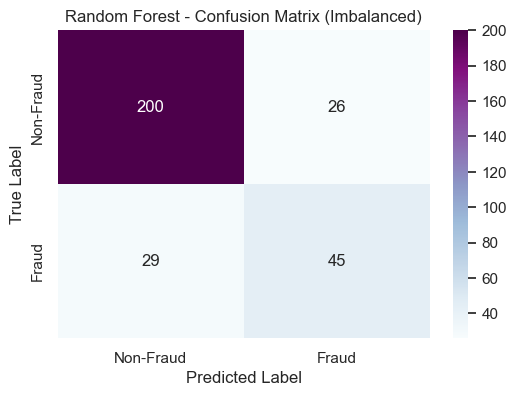

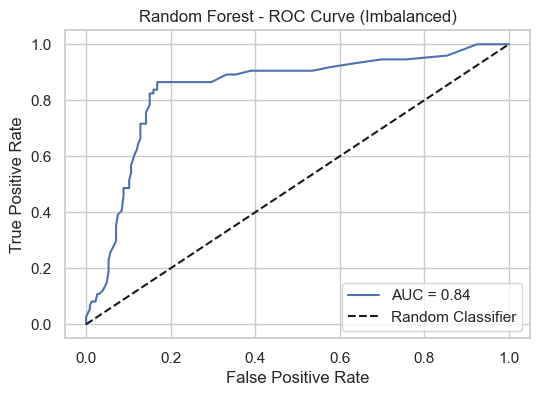


--- Random Forest - Cross-Validation Results ---
  Data Context: Imbalanced
Average Accuracy: 0.8400 (+/- 0.0331)
Average Precision: 0.6880 (+/- 0.0727)
Average Recall: 0.6582 (+/- 0.0753)
Average F1 Score: 0.6702 (+/- 0.0631)
Average AUC: 0.8620 (+/- 0.0367)
--------------------------------------------------

--- Decision Tree - Evaluation on Test Set ---
  Data Context: Imbalanced
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       226
           1       0.57      0.55      0.56        74

    accuracy                           0.79       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.78      0.79      0.79       300

Confusion Matrix:
[[195  31]
 [ 33  41]]
Accuracy: 0.7867
Precision: 0.5694
Recall: 0.5541
F1 Score: 0.5616
AUC: 0.7084
Training Time: 0.01 seconds


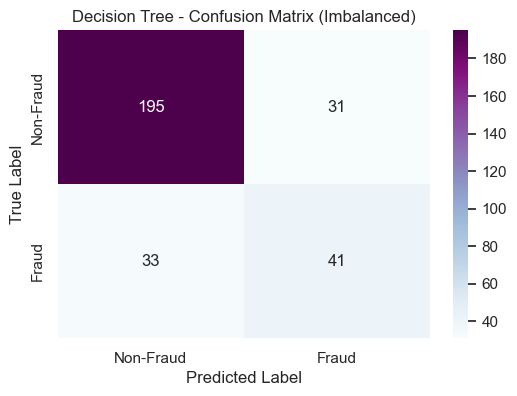

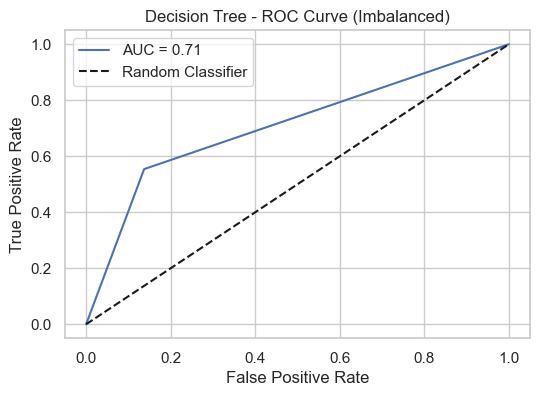


--- Decision Tree - Cross-Validation Results ---
  Data Context: Imbalanced
Average Accuracy: 0.7929 (+/- 0.0436)
Average Precision: 0.5808 (+/- 0.0888)
Average Recall: 0.5946 (+/- 0.0828)
Average F1 Score: 0.5869 (+/- 0.0840)
Average AUC: 0.7262 (+/- 0.0555)
--------------------------------------------------

--- XGBoost - Evaluation on Test Set ---
  Data Context: Imbalanced
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       226
           1       0.66      0.64      0.65        74

    accuracy                           0.83       300
   macro avg       0.77      0.76      0.77       300
weighted avg       0.83      0.83      0.83       300

Confusion Matrix:
[[202  24]
 [ 27  47]]
Accuracy: 0.8300
Precision: 0.6620
Recall: 0.6351
F1 Score: 0.6483
AUC: 0.8524
Training Time: 0.12 seconds


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


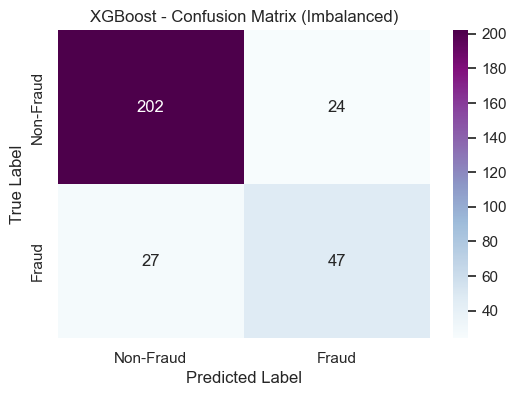

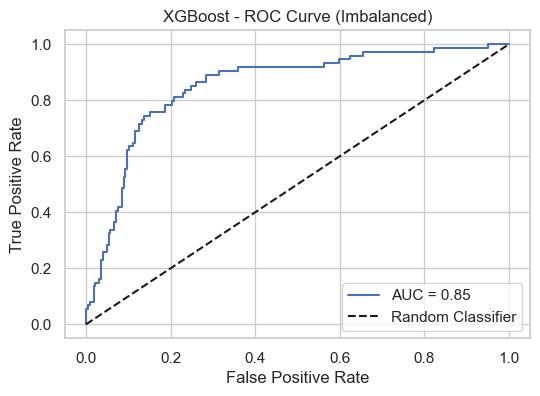


--- XGBoost - Cross-Validation Results ---
  Data Context: Imbalanced
Average Accuracy: 0.8457 (+/- 0.0254)
Average Precision: 0.7057 (+/- 0.0699)
Average Recall: 0.6588 (+/- 0.0234)
Average F1 Score: 0.6801 (+/- 0.0394)
Average AUC: 0.8731 (+/- 0.0253)
--------------------------------------------------

--- Gradient Boosting - Evaluation on Test Set ---
  Data Context: Imbalanced
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       226
           1       0.68      0.61      0.64        74

    accuracy                           0.83       300
   macro avg       0.78      0.76      0.77       300
weighted avg       0.83      0.83      0.83       300

Confusion Matrix:
[[205  21]
 [ 29  45]]
Accuracy: 0.8333
Precision: 0.6818
Recall: 0.6081
F1 Score: 0.6429
AUC: 0.8615
Training Time: 0.33 seconds


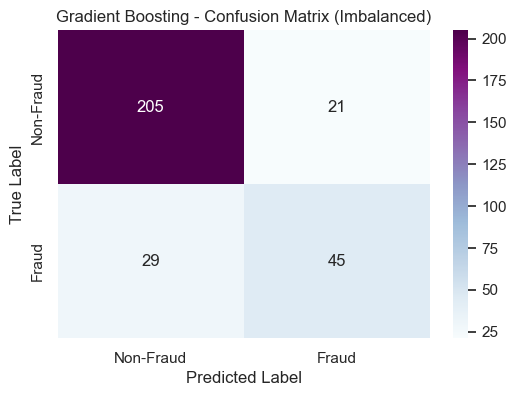

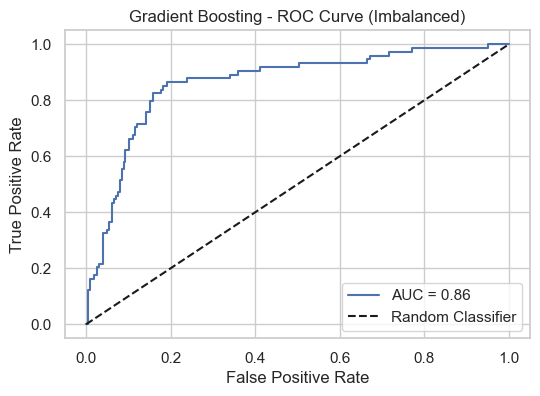


--- Gradient Boosting - Cross-Validation Results ---
  Data Context: Imbalanced
Average Accuracy: 0.8343 (+/- 0.0304)
Average Precision: 0.6676 (+/- 0.0641)
Average Recall: 0.6699 (+/- 0.0599)
Average F1 Score: 0.6669 (+/- 0.0532)
Average AUC: 0.8674 (+/- 0.0438)
--------------------------------------------------

--- Logistic Regression - Evaluation on Test Set ---
  Data Context: Imbalanced
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       226
           1       0.68      0.64      0.66        74

    accuracy                           0.84       300
   macro avg       0.78      0.77      0.78       300
weighted avg       0.83      0.84      0.83       300

Confusion Matrix:
[[204  22]
 [ 27  47]]
Accuracy: 0.8367
Precision: 0.6812
Recall: 0.6351
F1 Score: 0.6573
AUC: 0.8741
Training Time: 0.01 seconds


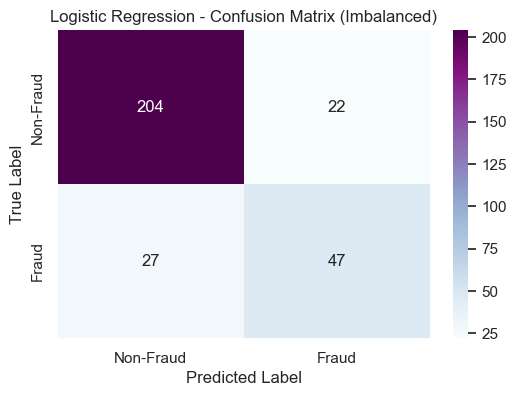

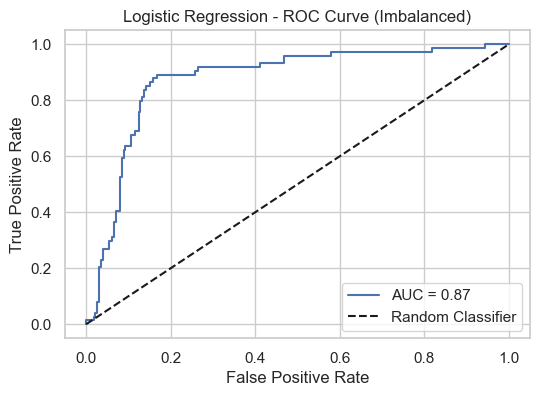


--- Logistic Regression - Cross-Validation Results ---
  Data Context: Imbalanced
Average Accuracy: 0.8543 (+/- 0.0288)
Average Precision: 0.7048 (+/- 0.0589)
Average Recall: 0.7103 (+/- 0.0757)
Average F1 Score: 0.7059 (+/- 0.0587)
Average AUC: 0.8839 (+/- 0.0390)
--------------------------------------------------

--- Evaluating Models on SMOTE Balanced Data ---

--- Random Forest - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       226
           1       0.64      0.72      0.68        74

    accuracy                           0.83       300
   macro avg       0.77      0.79      0.78       300
weighted avg       0.84      0.83      0.83       300

Confusion Matrix:
[[196  30]
 [ 21  53]]
Accuracy: 0.8300
Precision: 0.6386
Recall: 0.7162
F1 Score: 0.6752
AUC: 0.8552
Training Time: 0.30 seconds


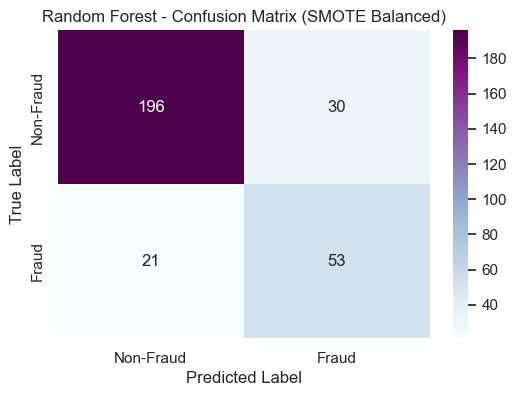

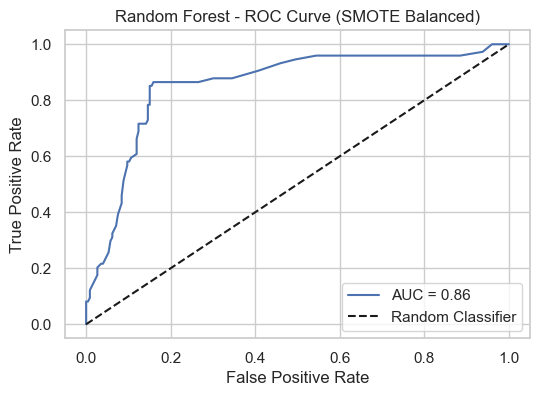


--- Random Forest - Cross-Validation Results ---
  Data Context: SMOTE Balanced
Average Accuracy: 0.9061 (+/- 0.0110)
Average Precision: 0.8805 (+/- 0.0239)
Average Recall: 0.9412 (+/- 0.0183)
Average F1 Score: 0.9094 (+/- 0.0090)
Average AUC: 0.9664 (+/- 0.0107)
--------------------------------------------------

--- Decision Tree - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       226
           1       0.52      0.55      0.54        74

    accuracy                           0.76       300
   macro avg       0.68      0.69      0.69       300
weighted avg       0.77      0.76      0.77       300

Confusion Matrix:
[[188  38]
 [ 33  41]]
Accuracy: 0.7633
Precision: 0.5190
Recall: 0.5541
F1 Score: 0.5359
AUC: 0.6930
Training Time: 0.02 seconds


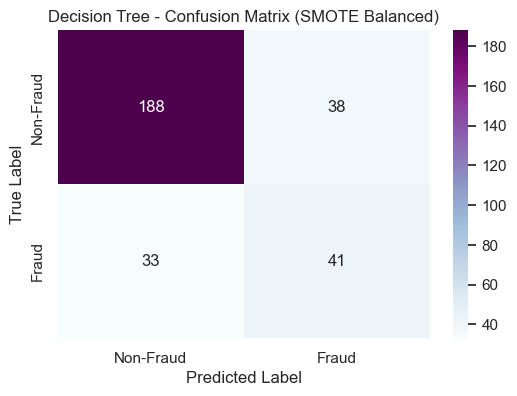

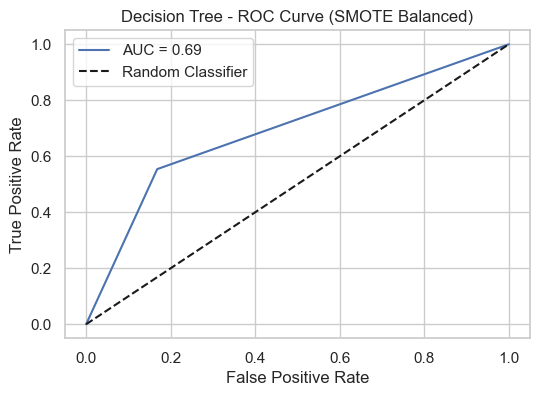


--- Decision Tree - Cross-Validation Results ---
  Data Context: SMOTE Balanced
Average Accuracy: 0.8558 (+/- 0.0214)
Average Precision: 0.8569 (+/- 0.0334)
Average Recall: 0.8558 (+/- 0.0166)
Average F1 Score: 0.8560 (+/- 0.0198)
Average AUC: 0.8558 (+/- 0.0215)
--------------------------------------------------

--- XGBoost - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       226
           1       0.68      0.65      0.66        74

    accuracy                           0.84       300
   macro avg       0.78      0.77      0.78       300
weighted avg       0.83      0.84      0.84       300

Confusion Matrix:
[[203  23]
 [ 26  48]]
Accuracy: 0.8367
Precision: 0.6761
Recall: 0.6486
F1 Score: 0.6621
AUC: 0.8436
Training Time: 0.10 seconds


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


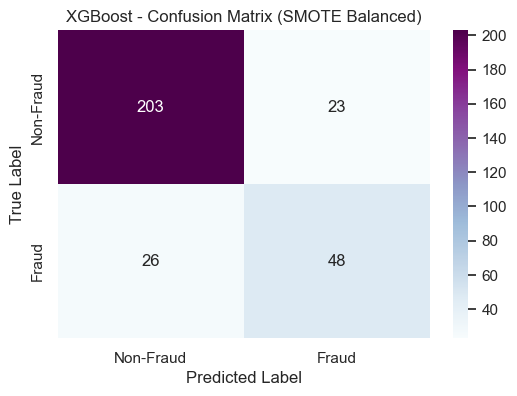

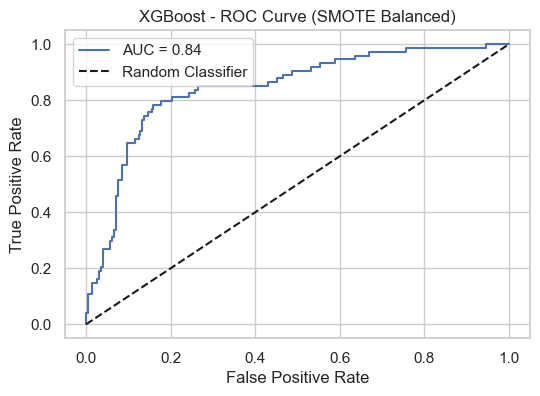


--- XGBoost - Cross-Validation Results ---
  Data Context: SMOTE Balanced
Average Accuracy: 0.9118 (+/- 0.0087)
Average Precision: 0.8962 (+/- 0.0130)
Average Recall: 0.9317 (+/- 0.0091)
Average F1 Score: 0.9135 (+/- 0.0079)
Average AUC: 0.9607 (+/- 0.0070)
--------------------------------------------------

--- Gradient Boosting - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       226
           1       0.68      0.69      0.68        74

    accuracy                           0.84       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.84      0.84      0.84       300

Confusion Matrix:
[[202  24]
 [ 23  51]]
Accuracy: 0.8433
Precision: 0.6800
Recall: 0.6892
F1 Score: 0.6846
AUC: 0.8512
Training Time: 0.56 seconds


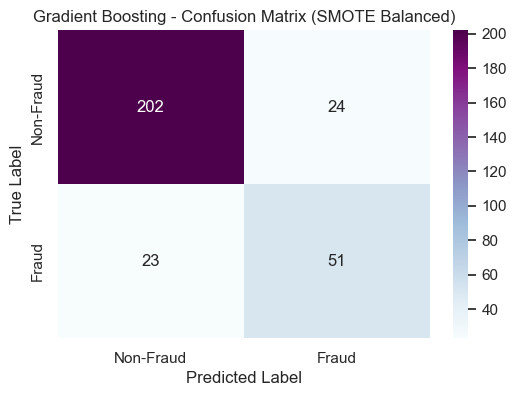

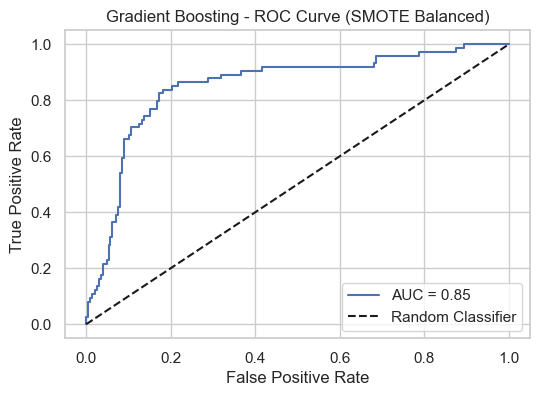


--- Gradient Boosting - Cross-Validation Results ---
  Data Context: SMOTE Balanced
Average Accuracy: 0.8956 (+/- 0.0131)
Average Precision: 0.8836 (+/- 0.0232)
Average Recall: 0.9127 (+/- 0.0248)
Average F1 Score: 0.8974 (+/- 0.0122)
Average AUC: 0.9508 (+/- 0.0093)
--------------------------------------------------

--- Logistic Regression - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       226
           1       0.67      0.84      0.74        74

    accuracy                           0.86       300
   macro avg       0.80      0.85      0.82       300
weighted avg       0.87      0.86      0.86       300

Confusion Matrix:
[[195  31]
 [ 12  62]]
Accuracy: 0.8567
Precision: 0.6667
Recall: 0.8378
F1 Score: 0.7425
AUC: 0.8719
Training Time: 0.01 seconds


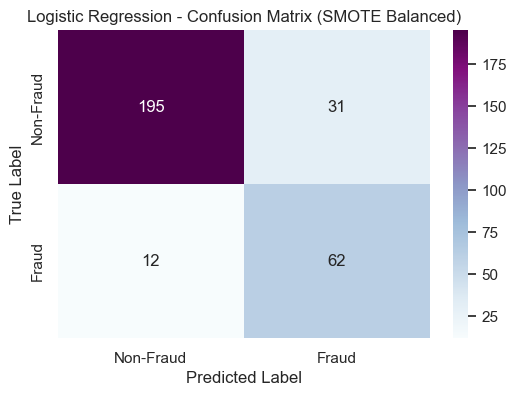

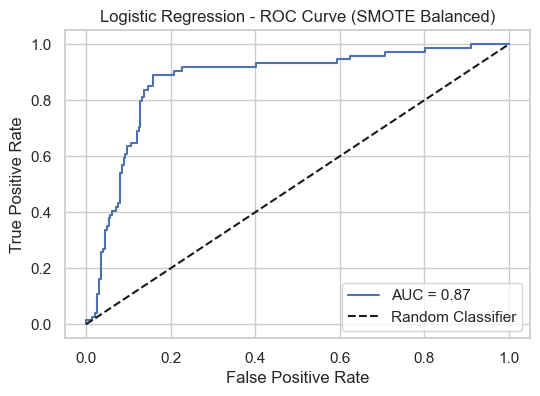


--- Logistic Regression - Cross-Validation Results ---
  Data Context: SMOTE Balanced
Average Accuracy: 0.8833 (+/- 0.0101)
Average Precision: 0.8574 (+/- 0.0159)
Average Recall: 0.9203 (+/- 0.0228)
Average F1 Score: 0.8874 (+/- 0.0098)
Average AUC: 0.9226 (+/- 0.0210)
--------------------------------------------------

--- Evaluating Models on ADASYN Balanced Data ---

--- Random Forest - Evaluation on Test Set ---
  Data Context: ADASYN Balanced
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       226
           1       0.64      0.76      0.70        74

    accuracy                           0.84       300
   macro avg       0.78      0.81      0.79       300
weighted avg       0.85      0.84      0.84       300

Confusion Matrix:
[[195  31]
 [ 18  56]]
Accuracy: 0.8367
Precision: 0.6437
Recall: 0.7568
F1 Score: 0.6957
AUC: 0.8580
Training Time: 0.30 seconds


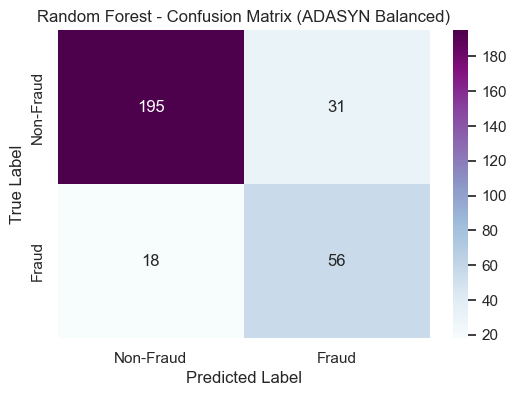

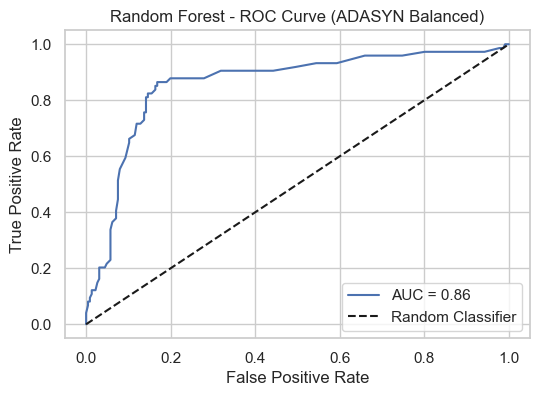


--- Random Forest - Cross-Validation Results ---
  Data Context: ADASYN Balanced
Average Accuracy: 0.9045 (+/- 0.0164)
Average Precision: 0.8729 (+/- 0.0216)
Average Recall: 0.9462 (+/- 0.0178)
Average F1 Score: 0.9078 (+/- 0.0149)
Average AUC: 0.9648 (+/- 0.0077)
--------------------------------------------------

--- Decision Tree - Evaluation on Test Set ---
  Data Context: ADASYN Balanced
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       226
           1       0.50      0.58      0.54        74

    accuracy                           0.75       300
   macro avg       0.68      0.70      0.68       300
weighted avg       0.77      0.75      0.76       300

Confusion Matrix:
[[183  43]
 [ 31  43]]
Accuracy: 0.7533
Precision: 0.5000
Recall: 0.5811
F1 Score: 0.5375
AUC: 0.6954
Training Time: 0.02 seconds


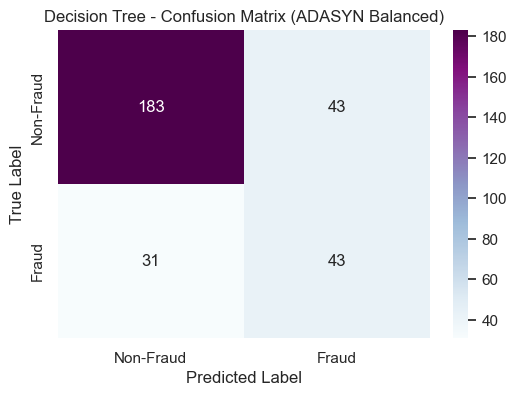

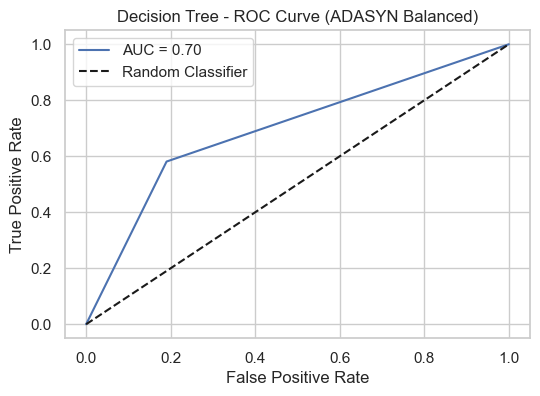


--- Decision Tree - Cross-Validation Results ---
  Data Context: ADASYN Balanced
Average Accuracy: 0.8682 (+/- 0.0227)
Average Precision: 0.8557 (+/- 0.0384)
Average Recall: 0.8865 (+/- 0.0176)
Average F1 Score: 0.8702 (+/- 0.0194)
Average AUC: 0.8683 (+/- 0.0226)
--------------------------------------------------

--- XGBoost - Evaluation on Test Set ---
  Data Context: ADASYN Balanced
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       226
           1       0.64      0.61      0.62        74

    accuracy                           0.82       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.82      0.82      0.82       300

Confusion Matrix:
[[201  25]
 [ 29  45]]
Accuracy: 0.8200
Precision: 0.6429
Recall: 0.6081
F1 Score: 0.6250
AUC: 0.8414
Training Time: 0.11 seconds


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


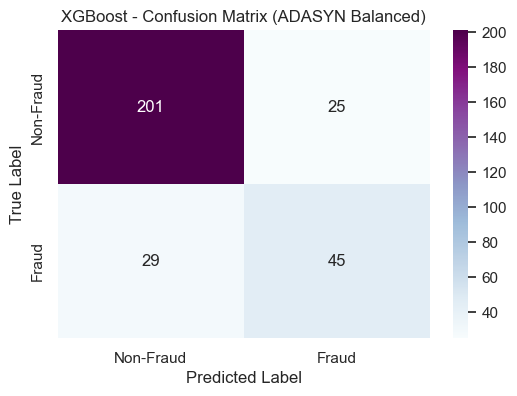

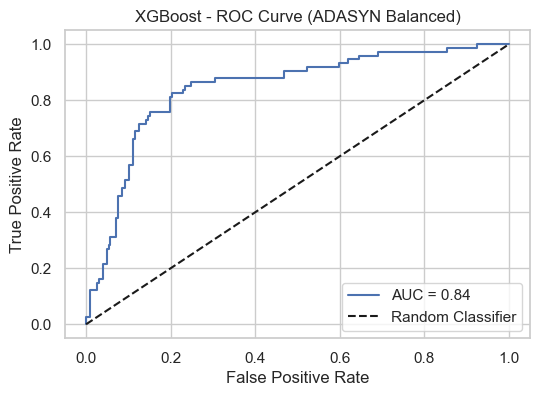


--- XGBoost - Cross-Validation Results ---
  Data Context: ADASYN Balanced
Average Accuracy: 0.9121 (+/- 0.0205)
Average Precision: 0.8963 (+/- 0.0128)
Average Recall: 0.9308 (+/- 0.0372)
Average F1 Score: 0.9129 (+/- 0.0214)
Average AUC: 0.9626 (+/- 0.0102)
--------------------------------------------------

--- Gradient Boosting - Evaluation on Test Set ---
  Data Context: ADASYN Balanced
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       226
           1       0.69      0.69      0.69        74

    accuracy                           0.85       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.85      0.85      0.85       300

Confusion Matrix:
[[203  23]
 [ 23  51]]
Accuracy: 0.8467
Precision: 0.6892
Recall: 0.6892
F1 Score: 0.6892
AUC: 0.8532
Training Time: 0.55 seconds


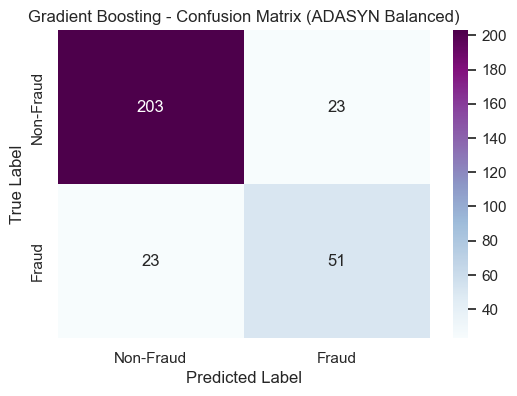

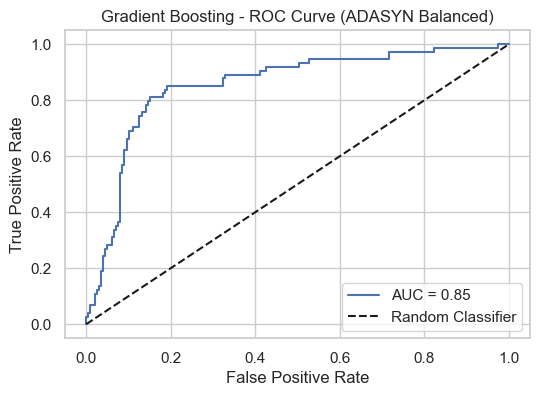


--- Gradient Boosting - Cross-Validation Results ---
  Data Context: ADASYN Balanced
Average Accuracy: 0.8968 (+/- 0.0229)
Average Precision: 0.8845 (+/- 0.0354)
Average Recall: 0.9135 (+/- 0.0251)
Average F1 Score: 0.8982 (+/- 0.0211)
Average AUC: 0.9565 (+/- 0.0109)
--------------------------------------------------

--- Logistic Regression - Evaluation on Test Set ---
  Data Context: ADASYN Balanced
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       226
           1       0.66      0.82      0.73        74

    accuracy                           0.85       300
   macro avg       0.80      0.84      0.82       300
weighted avg       0.87      0.85      0.86       300

Confusion Matrix:
[[195  31]
 [ 13  61]]
Accuracy: 0.8533
Precision: 0.6630
Recall: 0.8243
F1 Score: 0.7349
AUC: 0.8690
Training Time: 0.01 seconds


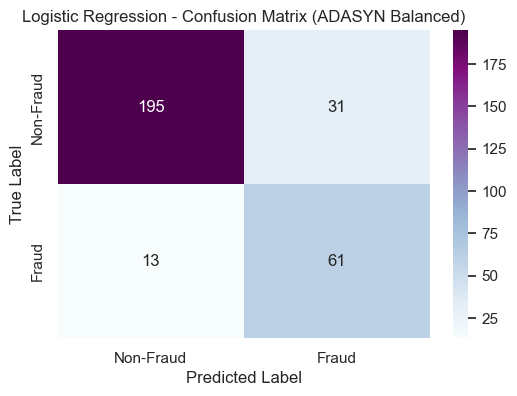

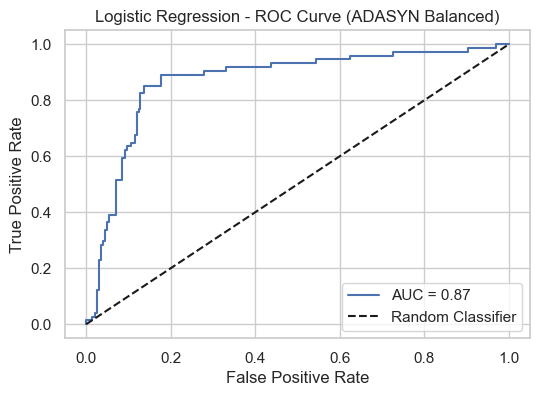


--- Logistic Regression - Cross-Validation Results ---
  Data Context: ADASYN Balanced
Average Accuracy: 0.8605 (+/- 0.0136)
Average Precision: 0.8454 (+/- 0.0158)
Average Recall: 0.8808 (+/- 0.0262)
Average F1 Score: 0.8624 (+/- 0.0138)
Average AUC: 0.9021 (+/- 0.0280)
--------------------------------------------------

--- Evaluating Models with KBest Feature Selection ---

Evaluating with Feature Selection Method: KBest

--- Random Forest (KBest) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       226
           1       0.63      0.72      0.67        74

    accuracy                           0.83       300
   macro avg       0.77      0.79      0.78       300
weighted avg       0.84      0.83      0.83       300

Confusion Matrix:
[[195  31]
 [ 21  53]]
Accuracy: 0.8267
Precision: 0.6310
Recall: 0.7162
F1 Score: 0.6709
AUC: 0.8646
Training Ti

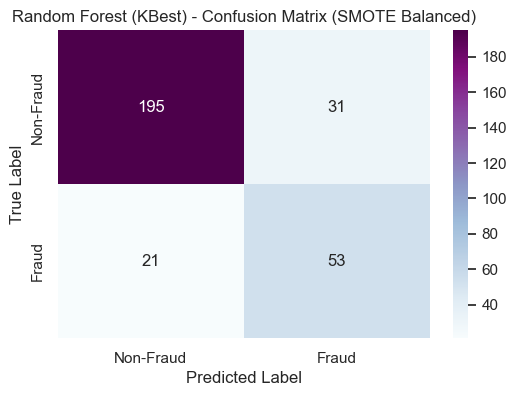

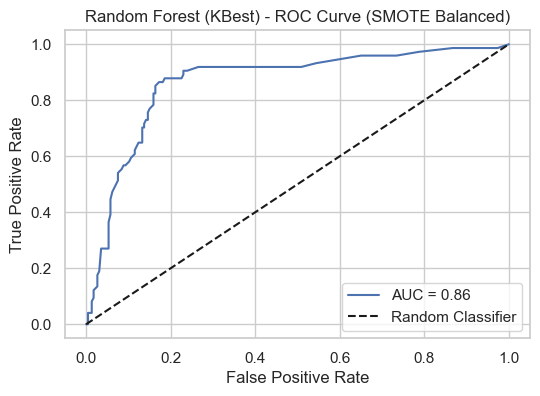


--- Random Forest (KBest) - Cross-Validation Results ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
Average Accuracy: 0.9051 (+/- 0.0198)
Average Precision: 0.8757 (+/- 0.0209)
Average Recall: 0.9450 (+/- 0.0290)
Average F1 Score: 0.9087 (+/- 0.0194)
Average AUC: 0.9470 (+/- 0.0157)
--------------------------------------------------

--- Decision Tree (KBest) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       226
           1       0.58      0.61      0.59        74

    accuracy                           0.79       300
   macro avg       0.72      0.73      0.73       300
weighted avg       0.80      0.79      0.80       300

Confusion Matrix:
[[193  33]
 [ 29  45]]
Accuracy: 0.7933
Precision: 0.5769
Recall: 0.6081
F1 Score: 0.5921
AUC: 0.7310
Training Time: 0.01 seconds


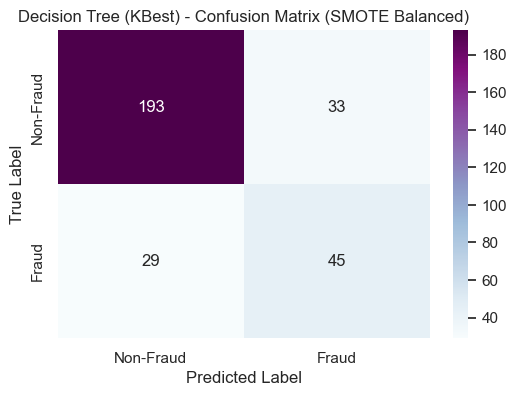

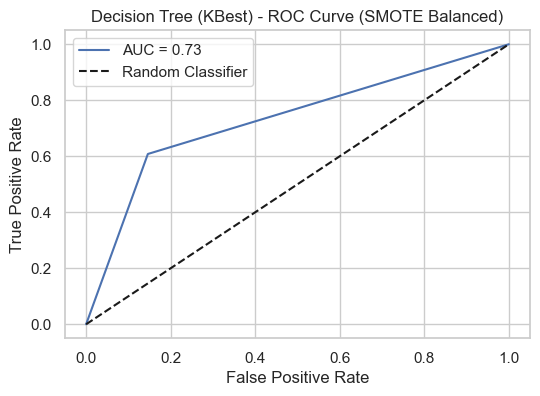


--- Decision Tree (KBest) - Cross-Validation Results ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
Average Accuracy: 0.8520 (+/- 0.0109)
Average Precision: 0.8595 (+/- 0.0202)
Average Recall: 0.8425 (+/- 0.0189)
Average F1 Score: 0.8506 (+/- 0.0108)
Average AUC: 0.8520 (+/- 0.0109)
--------------------------------------------------

--- XGBoost (KBest) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       226
           1       0.63      0.64      0.63        74

    accuracy                           0.82       300
   macro avg       0.75      0.76      0.75       300
weighted avg       0.82      0.82      0.82       300

Confusion Matrix:
[[198  28]
 [ 27  47]]
Accuracy: 0.8167
Precision: 0.6267
Recall: 0.6351
F1 Score: 0.6309
AUC: 0.8503
Training Time: 0.07 seconds


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


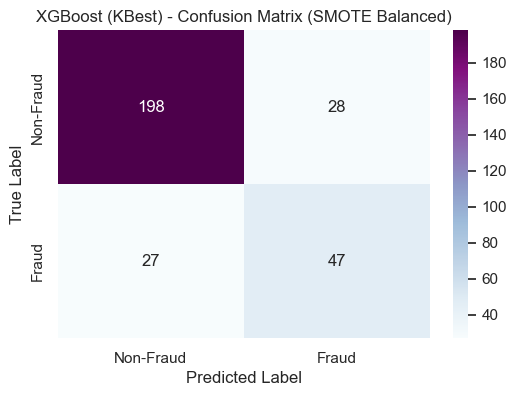

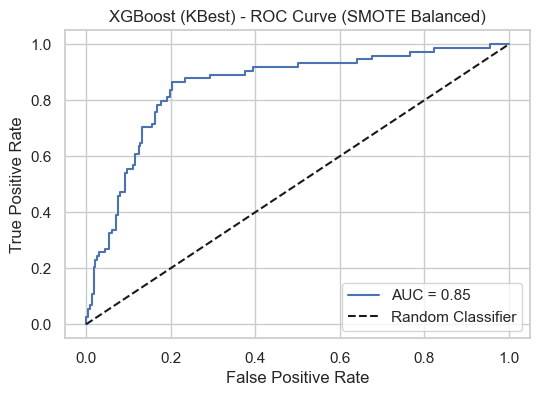


--- XGBoost (KBest) - Cross-Validation Results ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
Average Accuracy: 0.8871 (+/- 0.0156)
Average Precision: 0.8848 (+/- 0.0295)
Average Recall: 0.8919 (+/- 0.0184)
Average F1 Score: 0.8878 (+/- 0.0137)
Average AUC: 0.9490 (+/- 0.0131)
--------------------------------------------------

--- Gradient Boosting (KBest) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       226
           1       0.69      0.73      0.71        74

    accuracy                           0.85       300
   macro avg       0.80      0.81      0.81       300
weighted avg       0.86      0.85      0.85       300

Confusion Matrix:
[[202  24]
 [ 20  54]]
Accuracy: 0.8533
Precision: 0.6923
Recall: 0.7297
F1 Score: 0.7105
AUC: 0.8794
Training Time: 0.38 seconds


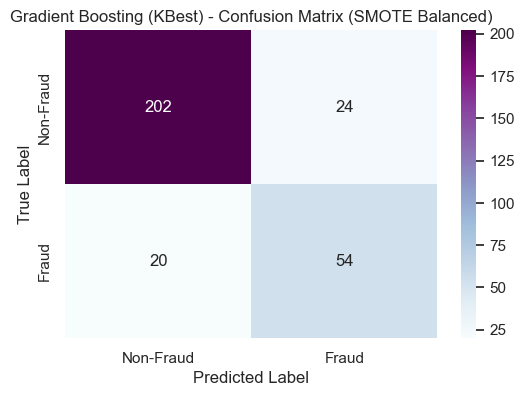

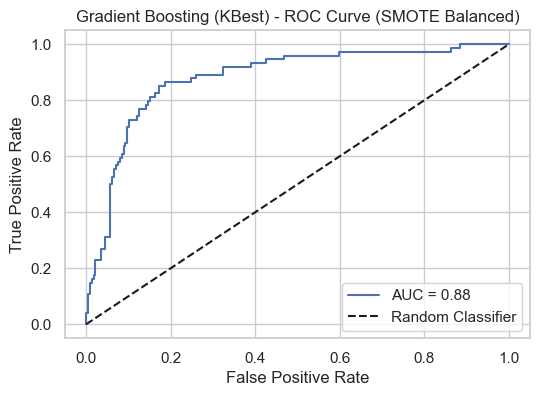


--- Gradient Boosting (KBest) - Cross-Validation Results ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
Average Accuracy: 0.8909 (+/- 0.0136)
Average Precision: 0.8852 (+/- 0.0239)
Average Recall: 0.8994 (+/- 0.0177)
Average F1 Score: 0.8919 (+/- 0.0124)
Average AUC: 0.9466 (+/- 0.0114)
--------------------------------------------------

--- Logistic Regression (KBest) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       226
           1       0.65      0.86      0.74        74

    accuracy                           0.85       300
   macro avg       0.80      0.86      0.82       300
weighted avg       0.88      0.85      0.86       300

Confusion Matrix:
[[192  34]
 [ 10  64]]
Accuracy: 0.8533
Precision: 0.6531
Recall: 0.8649
F1 Score: 0.7442
AUC: 0.8836
Training Time: 0.00 seconds


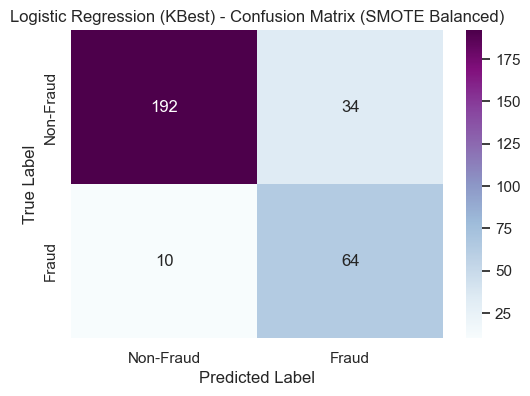

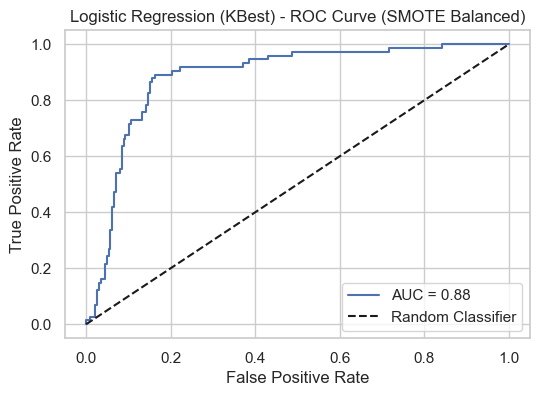


--- Logistic Regression (KBest) - Cross-Validation Results ---
  Data Context: SMOTE Balanced
  Feature Selection: KBest
Average Accuracy: 0.8814 (+/- 0.0119)
Average Precision: 0.8556 (+/- 0.0152)
Average Recall: 0.9184 (+/- 0.0243)
Average F1 Score: 0.8856 (+/- 0.0117)
Average AUC: 0.9206 (+/- 0.0217)
--------------------------------------------------


In [6]:
# ======================================================================
#                     Model Evaluation and Comparison
# ======================================================================
#Táto +cast kódu predstavuje hlavnú fázu  vyhodnocovania a porovnávania modelov strojového učenia pre detekciu podvodov. Cieľom je systematicky otestovať rôzne modely
# a prístupy k dátam (nevyvážené, vyvážené pomocou SMOTE/ADASYN a s výberom relevantnych vlastností),
# aby sme identifikovali najvýkonnejší model
#
print("\n==== 5. Model Evaluation and Comparison ====")

# Vyhodnocovanie na nevyvážených dátach - Modely sa najprv trénujú a testujú na pôvodných, nevyvážených dátach
#Pre každý model sa vykoná jednorazové vyhodnotenie a krizova validatacia
print("\n--- Evaluating Models on Imbalanced Data (Original Scaled) ---")
for name, model in models.items():
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, name, data_context="Imbalanced")
    evaluate_model_cv(model, X_train_scaled, y_train, name, data_context="Imbalanced")

#Dalej sme pokracovali s vyhodnocovanim na vyvážených dátach SMOTE a ADASYN
#MOdely sa natrenovali na datach ktore vyvazili triedy podla danej techniky, nasledne sa vykoná jednorazové vyhodnotenie a krížová validácia
# SMOTE 
print("\n--- Evaluating Models on SMOTE Balanced Data ---")
for name, model in models.items():
    evaluate_model(model, X_train_smote, y_train_smote, X_test_scaled, y_test, f"{name}", data_context="SMOTE Balanced")
    evaluate_model_cv(model, X_train_smote, y_train_smote, f"{name}", data_context="SMOTE Balanced")

# ADASYN 
print("\n--- Evaluating Models on ADASYN Balanced Data ---")
for name, model in models.items():
    evaluate_model(model, X_train_adasyn, y_train_adasyn, X_test_scaled, y_test, f"{name}", data_context="ADASYN Balanced")
    evaluate_model_cv(model, X_train_adasyn, y_train_adasyn, f"{name}", data_context="ADASYN Balanced")

# Feature Selection (KBest only)
#V poslednej iterácii sa modely testujú na dátach, ktoré boli vyvážené pomocou SMOTE
#Tento krok skúma, či redukcia dimenzionality a výber relevantných vlastností môže zlepšiť výkon modelov a znížiť zložitosť.
#Pre každý model a pre každú metódu výberu vlastností sa vykoná vyhodnotenie.
print("\n--- Evaluating Models with KBest Feature Selection ---")
for method, (X_train_fs, X_test_fs, fs_features) in feature_selection_methods_smote_data.items():
    print(f"\nEvaluating with Feature Selection Method: {method}")
    for name, model in models.items():
        evaluate_model(model, X_train_fs, y_train_smote, X_test_fs, y_test,
                       f"{name} ({method})", data_context="SMOTE Balanced", feature_selection_method=method)
        evaluate_model_cv(model, X_train_fs, y_train_smote,
                          f"{name} ({method})", data_context="SMOTE Balanced", feature_selection_method=method)




==== 6. Model Tuning & Ensemble ====

--- Hyperparameter Tuning for XGBoost (using SMOTE Balanced Data) ---
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 0.7}


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:13:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Tuned XGBoost - Evaluation on Test Set ---
  Data Context: SMOTE Balanced, Tuned
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       226
           1       0.64      0.66      0.65        74

    accuracy                           0.83       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.83      0.83      0.83       300

Confusion Matrix:
[[199  27]
 [ 25  49]]
Accuracy: 0.8267
Precision: 0.6447
Recall: 0.6622
F1 Score: 0.6533
AUC: 0.8438
Training Time: 0.20 seconds


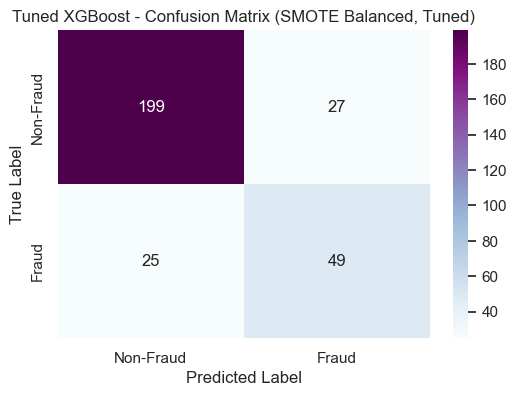

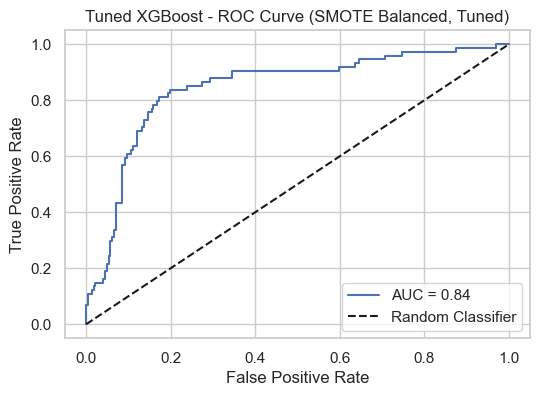


--- Hyperparameter Tuning for Random Forest (using SMOTE Balanced Data) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini'}

--- Tuned Random Forest - Evaluation on Test Set ---
  Data Context: SMOTE Balanced, Tuned
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       226
           1       0.63      0.72      0.67        74

    accuracy                           0.83       300
   macro avg       0.77      0.79      0.78       300
weighted avg       0.84      0.83      0.83       300

Confusion Matrix:
[[195  31]
 [ 21  53]]
Accuracy: 0.8267
Precision: 0.6310
Recall: 0.7162
F1 Score: 0.6709
AUC: 0.8469
Training Time: 0.87 seconds


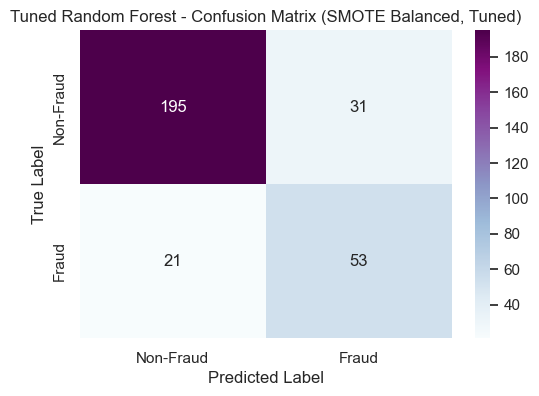

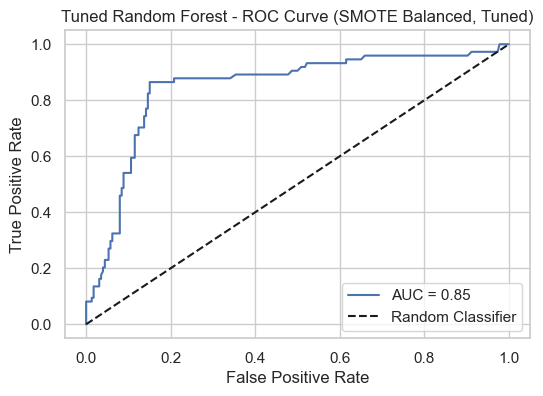


--- Building Ensemble Model with Logistic Regression ---


C:\Users\Miriam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:14:12] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Ensemble Model (XGB + RF + LR) - Evaluation on Test Set ---
  Data Context: SMOTE Balanced Training
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       226
           1       0.65      0.72      0.68        74

    accuracy                           0.84       300
   macro avg       0.78      0.80      0.79       300
weighted avg       0.84      0.84      0.84       300

Confusion Matrix:
[[198  28]
 [ 21  53]]
Accuracy: 0.8367
Precision: 0.6543
Recall: 0.7162
F1 Score: 0.6839
AUC: 0.8579
Training Time: 1.08 seconds


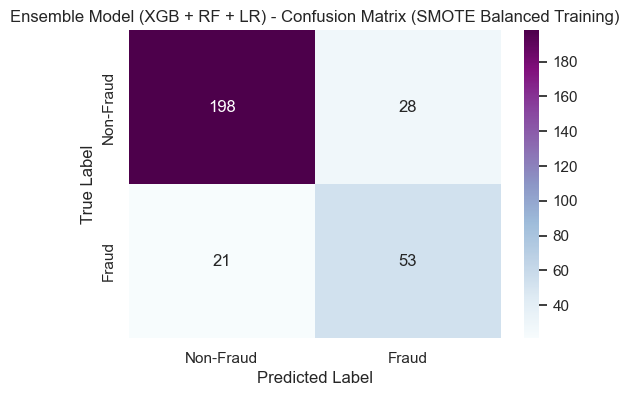

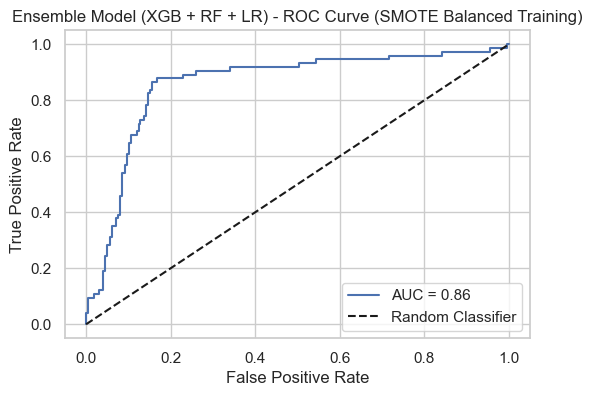

----------------------------------------------------------------------


In [7]:
# ======================================================================
#                     Model Tuning & Ensemble
# ======================================================================
#Táto časť kódu sa zameriava na ďalšiu úroveň zlepšovania modelov,konkrétne na ladenie hyperparametrov (tuning) a vytváranie ensemble modelu.
# Cieľom je posunúť výkon detektora podvodov nad rámec základného vyhodnocovania prostredníctvom systematickej optimalizácie a kombinácie silných stránok viacerých modelov.
#
print("\n==== 6. Model Tuning & Ensemble ====")


# Ladenie hyperparametrov pre XGBoost:Definovali sme rozsiahlu mriežku hyperparametrov systematicky iteruje cez všetky kombinácie týchto parametrov
#a trénuje XGBoost model s každou kombináciou na vyvážených dátach sMOTE
# Výsledný "naladený" XGBoost model  sa následne vyhodnotí na testovacej sade
#tento krok ilustruje iteratívny prístup k nájdeniu optimálnej konfigurácie pre konkrétny model
print("\n--- Hyperparameter Tuning for XGBoost (using SMOTE Balanced Data) ---")
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 0.1, 0.5]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search_xgb.fit(X_train_smote, y_train_smote)

print("Best XGBoost parameters:", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_

evaluate_model(
    best_xgb,
    X_train_smote,
    y_train_smote,
    X_test_scaled,
    y_test,
    "Tuned XGBoost",
    data_context="SMOTE Balanced, Tuned"
)

# Optimalizácia Random Forest pomocou RandomizedSearchCV
#Definuje sa distribúcia hyperparametrov RandomizedSearchCV náhodne iteruje cez definovaný počet kombinácií hyperparametrov,
# čo je efektívnejšie pre väčšie priestory hyperparametrov, Aj tento model je naladený a podrobí sa vyhodnoteniu na testovacej sade
# tento krok opäť zdôrazňuje iteratívne vylaďovanie jednotlivých komponentov
print("\n--- Hyperparameter Tuning for Random Forest (using SMOTE Balanced Data) ---")
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', 0.8, 1.0]
}

random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=50,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_smote, y_train_smote)

print("Best Random Forest parameters:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_

evaluate_model(
    best_rf,
    X_train_smote,
    y_train_smote,
    X_test_scaled,
    y_test,
    "Tuned Random Forest",
    data_context="SMOTE Balanced, Tuned"
)

# Vytvorenie a vyhodnotenie Ensemble modelu
#Používajú sa predtým optimalizované modely (XGBoost a Random Forest) a základný Logistic Regression
#VotingClassifier kombinuje predikcie týchto modelov (s váhami) do jedného, silnejšieho ensemble modelu.
#tento prístup predpokladá, že kombináciou viacerých dobrých modelov možno dosiahnuť lepší a robustnejší uspech modelu,
#než ktorýkoľvek individuálny model sám o sebe
#Celý ensemble model sa následne komplexne vyhodnotí
print("\n--- Building Ensemble Model with Logistic Regression ---")
base_lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

ensemble = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),          
        ('rf', best_rf),              
        ('lr', base_lr)               
    ],
    voting='soft',
    weights=[0.4, 0.3, 0.3]          
)

evaluate_model(
    ensemble,
    X_train_smote,
    y_train_smote,
    X_test_scaled,
    y_test,
    "Ensemble Model (XGB + RF + LR)",
    data_context="SMOTE Balanced Training"
)
print("-" * 70)

#Každý z týchto krokov predstavuje iteráciu v procese vylepšovania, kde sa na základe predchádzajúcich výsledkov
# prijímajú rozhodnutia o ďalšom postupe (napr. ktorý model ladiť, aké metódy použiť, aké modely kombinovať)
# Cieľom je neustále zvyšovať výkon a robustnosť detektora podvodov.


==== 7. Model Interpretability with SHAP (Logistic Regression) ====

Global Feature Importance (SHAP Summary Plot - Bar)


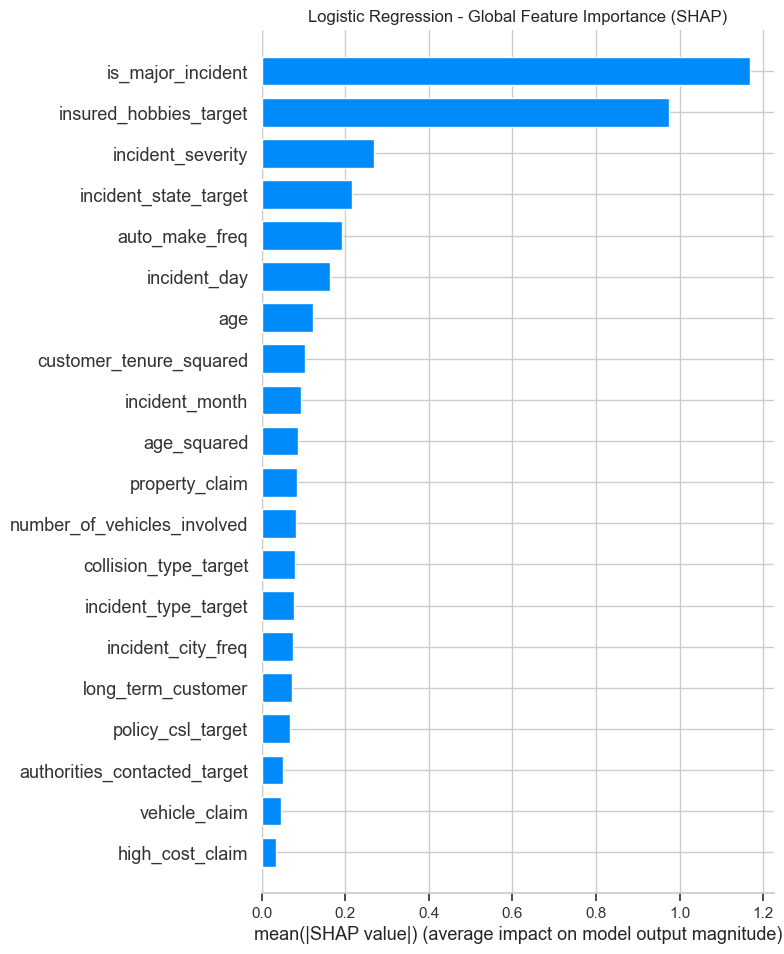


SHAP Summary Plot (Dots) - Feature Impact and Direction


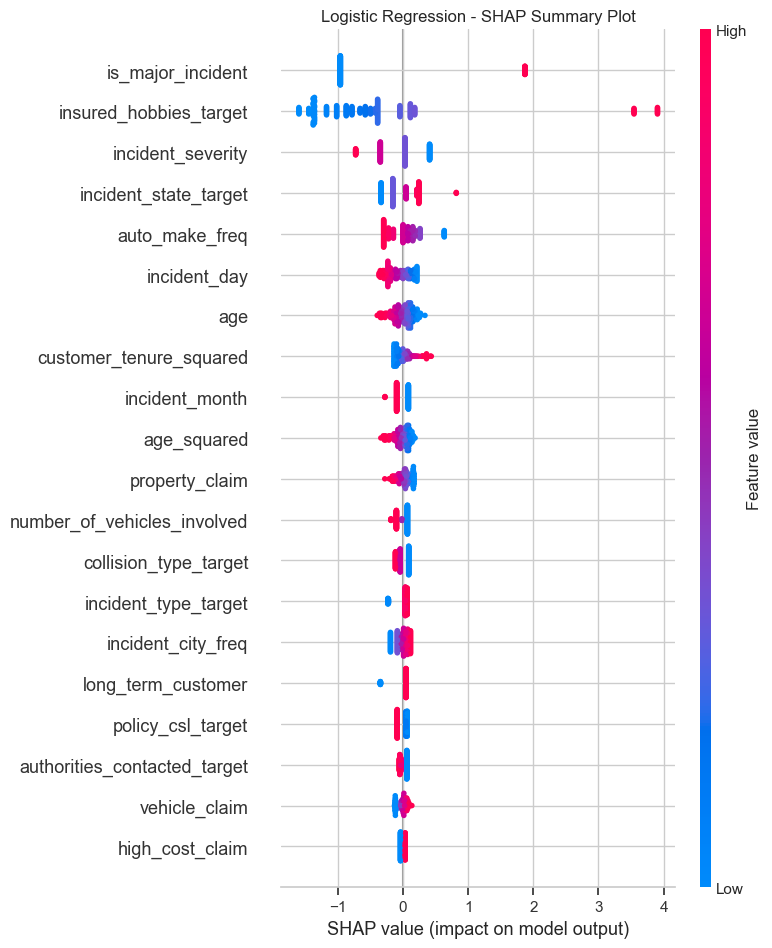


Explaining a single fraudulent prediction (Original Test Index: 823)


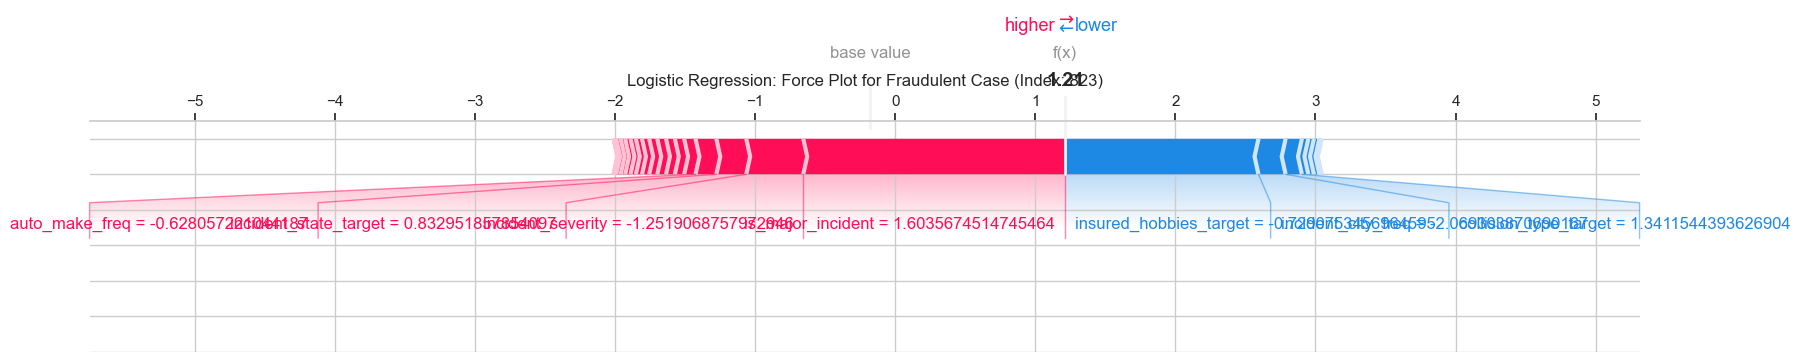

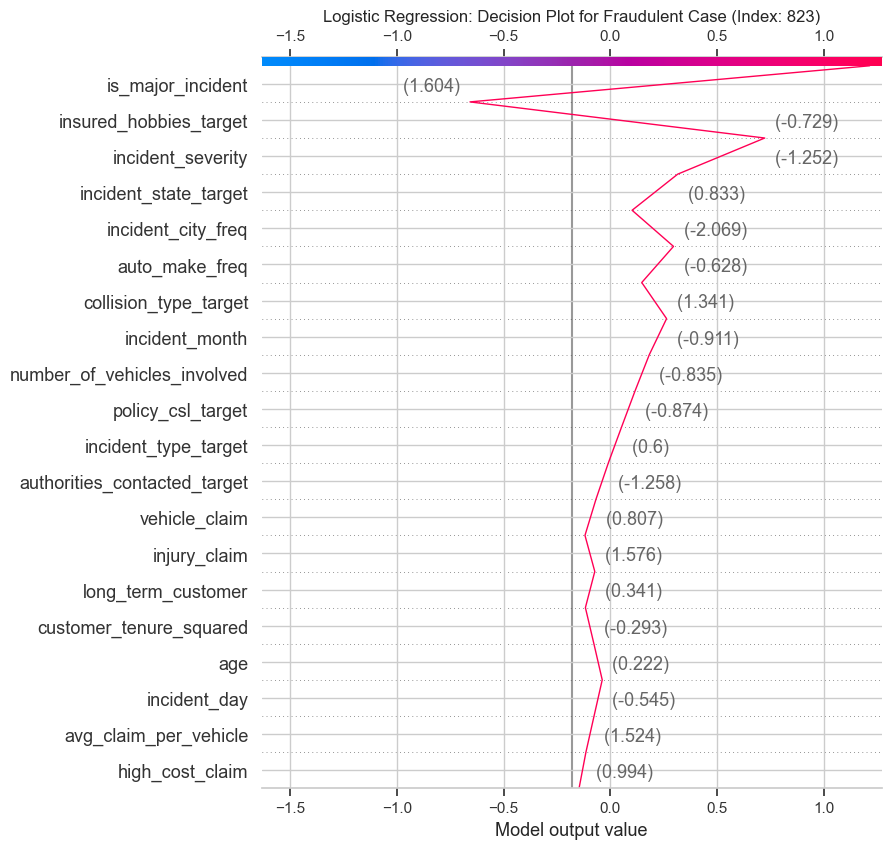


SHAP Dependence Plot for top feature: 'is_major_incident'


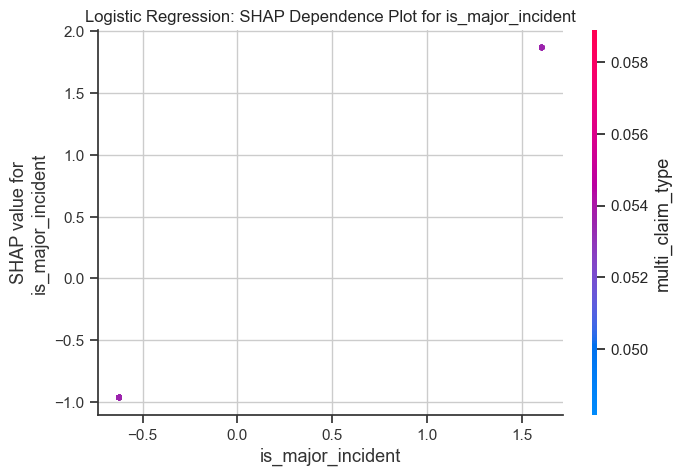


Logistic Regression Coefficients:
                    Feature  Coefficient
26   insured_hobbies_target     1.329645
14        is_major_incident     1.272521
27    incident_state_target     0.258269
20  customer_tenure_squared     0.141916
15       long_term_customer     0.119886
29     incident_type_target     0.107002
21       incident_city_freq     0.092976
1             vehicle_claim     0.066149
16          high_cost_claim     0.035497
11     incident_day_of_week     0.029010

...
                        Feature  Coefficient
5   number_of_vehicles_involved    -0.085682
24        collision_type_target    -0.086701
17             multi_claim_type    -0.087455
9                incident_month    -0.093351
3                property_claim    -0.109482
19                  age_squared    -0.114886
6                           age    -0.156501
10                 incident_day    -0.167824
22               auto_make_freq    -0.243221
0             incident_severity    -0.355351


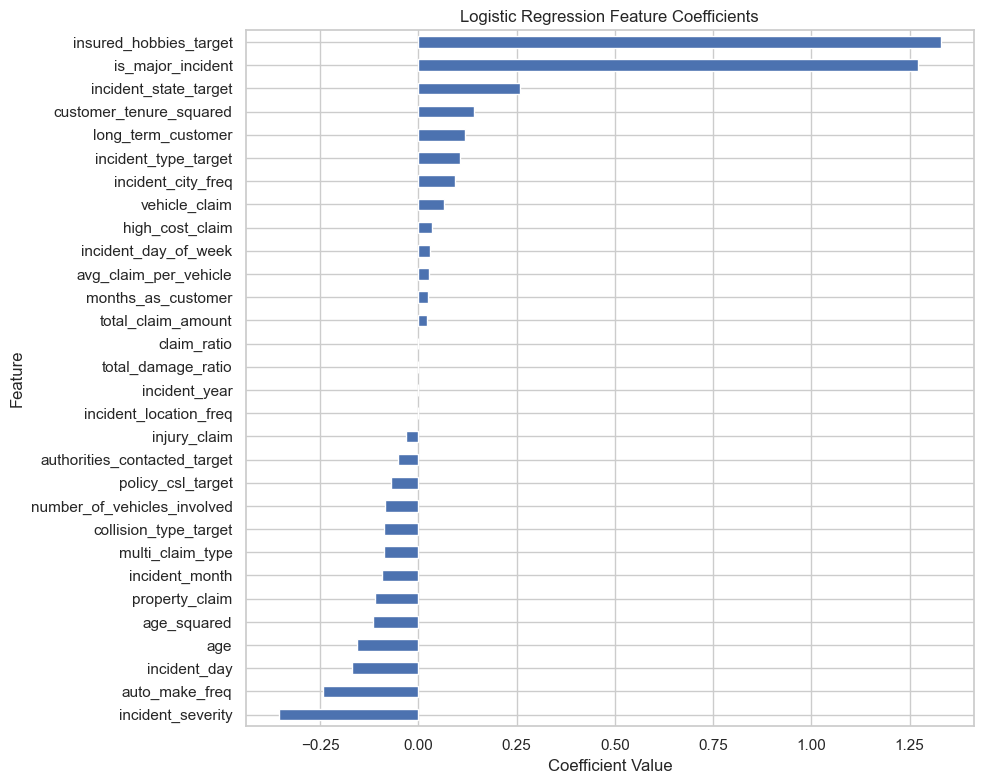

----------------------------------------------------------------------


In [8]:
# ======================================================================
#       Model Interpretability with SHAP (Logistic Regression)
# ======================================================================
#Táto časť kódu sa zameriava na interpretovateľnosť modelu, čo je kritický krok
# v procese vývoja strojového učenia, najmä pri citlivých úlohách, ako je detekcia podvodov.
# Ide o proces porozumenia, ako model dospieva k svojim predikciám, a nie o priame ladenie modelu.

# 1.  Trénovanie modelu pre interpretáciu: Natrénuje sa špecifická inštancia
# logistickej regresie (lr_for_interpretability), preferovaná pre interpretáciu vďaka jej lineárnej povahe.
#Ide o iteratívny výber modelu pre hĺbkovú analýzu.
# 2.  Generovanie SHAP hodnôt: Vytvorí sa `shap.LinearExplainer` a iteratívne sa vypočítajú SHAP hodnotypre vzorku dát. Tieto hodnoty kvantifikujú vplyv každej vlastnosti na predikciu,
# a to individuálne aj na celkovej úrovni.
# 3.  Globálna interpretácia (SHAP Summary Plots): Kód generuje a vizualizuje
# SHAP súhrnné grafy (stĺpcový a bodový) pre objavenie najvplyvnejších faktorov a ich správania.
# 4.  Lokálna interpretácia (Force a Decision Plots): Zameriava sa na vysvetľovanie
# jednotlivých predikcií, najmä podvodných prípadov, pomocou Force a Decision Plotov
#  pre hĺbkové preskúmanie konkrétnych transakcií.
# 5.  SHAP Dependence Plot a koeficienty logistickej regresie:Vizualizuje sa vzťah medzi
# hodnotou vlastnosti a jej SHAP hodnotou (Dependence Plot) a zobrazujú sa koeficienty
#  logistickej regresie. Tieto vizualizácie umožňujú  overovanie a porovnávanie
# dôležitosti vlastností z rôznych perspektív.
# Celkovo je táto sekcia o  procese pochopenia a vysvetľovania už natrénovaných modelov,
# čo je nevyhnutné pre získanie dôvery a úspešné nasadenie v reálnom svete.
print("\n==== 7. Model Interpretability with SHAP (Logistic Regression) ====")

# Train a Logistic Regression model for interpretation
lr_for_interpretability = LogisticRegression(C=0.1, solver='liblinear', random_state=42, max_iter=1000)
lr_for_interpretability.fit(X_train_smote, y_train_smote)

# Create SHAP explainer for Logistic Regression
explainer = shap.LinearExplainer(
    lr_for_interpretability, 
    X_train_smote, 
    feature_names=feature_names_after_encoding
)

# Get SHAP values for a sample of the test data
sample_X_test_scaled = X_test_scaled.sample(min(200, X_test_scaled.shape[0]), random_state=42)
shap_values = explainer.shap_values(sample_X_test_scaled)

# For linear models, SHAP values are already for the positive class
shap_values_for_positive_class = shap_values

print("\nGlobal Feature Importance (SHAP Summary Plot - Bar)")
shap.summary_plot(
    shap_values_for_positive_class, 
    sample_X_test_scaled,
    feature_names=feature_names_after_encoding,
    plot_type="bar",
    show=False
)
plt.title('Logistic Regression - Global Feature Importance (SHAP)')
plt.show()

print("\nSHAP Summary Plot (Dots) - Feature Impact and Direction")
shap.summary_plot(
    shap_values_for_positive_class, 
    sample_X_test_scaled,
    feature_names=feature_names_after_encoding,
    show=False
)
plt.title('Logistic Regression - SHAP Summary Plot')
plt.show()

# Individual prediction explanation
fraud_test_indices = y_test[y_test == 1].index
if not fraud_test_indices.empty:
    original_idx_for_force_plot = fraud_test_indices[0]
    sample_data_for_force_plot = X_test_scaled.loc[[original_idx_for_force_plot]]
    
    # Get SHAP values for this specific instance
    single_instance_shap_values = explainer.shap_values(sample_data_for_force_plot)
    
    print(f"\nExplaining a single fraudulent prediction (Original Test Index: {original_idx_for_force_plot})")
    
    # Create force plot
    shap.force_plot(
        explainer.expected_value,
        single_instance_shap_values[0],
        sample_data_for_force_plot.iloc[0],
        feature_names=feature_names_after_encoding,
        matplotlib=True,
        show=False
    )
    plt.title(f'Logistic Regression: Force Plot for Fraudulent Case (Index: {original_idx_for_force_plot})')
    plt.show()
    
    # Create decision plot
    shap.decision_plot(
        explainer.expected_value,
        single_instance_shap_values,
        sample_data_for_force_plot,
        feature_names=feature_names_after_encoding,
        show=False
    )
    plt.title(f'Logistic Regression: Decision Plot for Fraudulent Case (Index: {original_idx_for_force_plot})')
    plt.show()
else:
    print("\nNo fraudulent cases found in test set to generate individual explanation plots.")

# Dependence plot for top feature
if shap_values_for_positive_class.shape[1] > 0:
    # Get the most important feature (highest mean absolute SHAP value)
    mean_abs_shap = np.mean(np.abs(shap_values_for_positive_class), axis=0)
    top_feature_index = np.argmax(mean_abs_shap)
    top_feature_name = feature_names_after_encoding[top_feature_index]
    
    print(f"\nSHAP Dependence Plot for top feature: '{top_feature_name}'")
    
    shap.dependence_plot(
        top_feature_name,
        shap_values_for_positive_class,
        sample_X_test_scaled,
        feature_names=feature_names_after_encoding,
        show=False
    )
    plt.title(f'Logistic Regression: SHAP Dependence Plot for {top_feature_name}')
    plt.show()
    
    # Show feature coefficients
    print("\nLogistic Regression Coefficients:")
    coef_df = pd.DataFrame({
        'Feature': feature_names_after_encoding,
        'Coefficient': lr_for_interpretability.coef_[0]
    }).sort_values('Coefficient', ascending=False)
    
    # Highlight top features
    print(coef_df.head(10))
    print("\n...")
    print(coef_df.tail(10))
    
    # Plot coefficients
    plt.figure(figsize=(10, 8))
    coef_df.set_index('Feature')['Coefficient'].sort_values().plot(kind='barh')
    plt.title('Logistic Regression Feature Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough features for SHAP dependence plot.")

print("-" * 70)